In [8]:
# Librerías que usamos
import numpy as np 
import pandas as pd 
from scipy.integrate import odeint
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt 
from scipy.optimize import differential_evolution
from scipy.optimize import NonlinearConstraint, LinearConstraint, Bounds

In [9]:
phrases_information = pd.read_csv('../Extraccion_datos_leskovec/Root_phrases.txt', delimiter='\t')

### Modelo a ajustar aquí 

Solo patada en los medios:

$$ \dot n = - p n + \alpha o_{\tau} $$

$$ \dot o = -q o + r n + k o o_{\tau}$$

donde $o_{\tau} = o(t - \tau)$ que puede ser reemplazada por un conjunto finito de ecuaciones diferenciales ordinarias que simulen una distribución de delays.


In [10]:
def integrate_model(args, tmax, x0):
    
    p, alpha, q, r, k, tau = args
    tt = np.arange(0, tmax, 0.01)
         
    def model(x, t, p, alpha, q, r, k, tau):
         
            n = len(x)
            fs = np.zeros(n)
            
            fs[0] = - p * x[0] + alpha * x[-1]
            fs[1] = - q * x[1] + r * x[0] + k * x[1] * x[-1]
            for i in range(2, n):
                fs[i] = ((n-2)/tau) * (x[i-1] - x[i])
    
            return fs
        
    # Integración numérica del modelo 
    yint = odeint(model, x0, tt, args=(p, alpha, q, r, k, tau), full_output=0)

    return tt, yint        

### Ajuste de datos

In [11]:
all_data = pd.read_csv('Analisis/Parametros_finales.csv', index_col = 0)

In [12]:
all_data.head()

,fileid,p,alpha,q,r,k,tau,m0,b0,error,p_tilde,q_tilde,alpha_tilde,r_tilde,k_tilde,tau_tilde
0,2397767,0.077835,0.001396,0.312934,0.350682,0.575831,68.168081,1.000000,1.000000,0.014379,1.0,4.020491,0.017942,4.505470,7.398119,5.305846
1,1214612,0.135511,0.008321,0.461608,0.413892,0.442661,16.127937,0.894919,0.890439,0.011273,1.0,3.406421,0.061094,3.069670,2.908710,2.185517
2,1518688,0.171239,0.001273,0.125884,0.031279,-0.101911,116.175745,0.907296,0.952006,0.007711,1.0,0.735134,0.007798,0.174085,-0.566575,19.893796
3,1510105,0.097321,0.010770,0.236805,0.196625,0.003070,38.722599,1.034615,1.003087,0.015781,1.0,2.433228,0.107294,2.083871,0.031638,3.768534
4,1134876,0.074291,0.023095,0.280250,0.264289,-0.171589,80.580418,0.999539,0.990230,0.020916,1.0,3.772337,0.307977,3.590947,-2.287126,5.986378


In [31]:
# Fileid a visualizar
fileid = 4691
root_phrase = phrases_information[phrases_information['<ClusterId>']==fileid]['<Root>'].to_list()[0]

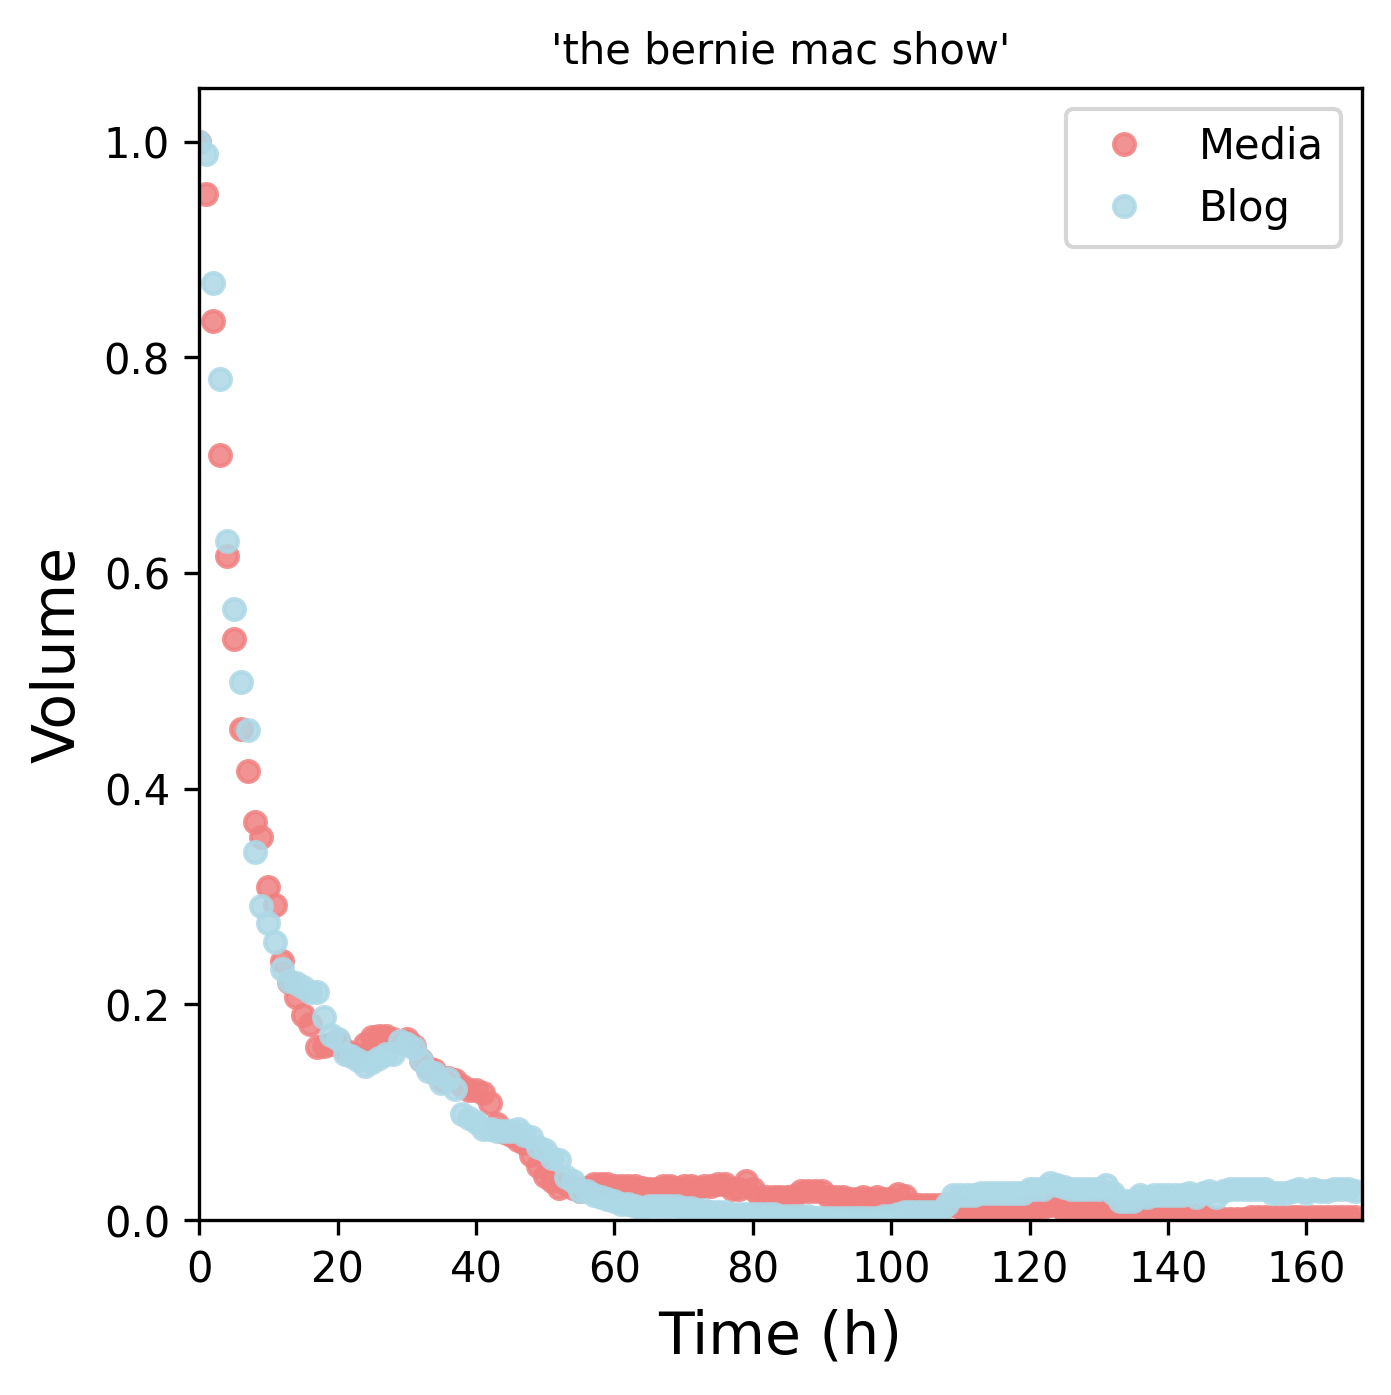

In [32]:
### Datos
filename = f'../Extraccion_datos_leskovec/Series_a_ajustar/Corte_id{fileid}.csv'

data = pd.read_csv(filename, parse_dates=[0])
data.set_index('time', inplace=True)
data.media = data.media.div(data.media.max())
data.blog = data.blog.div(data.blog.max())

init_index = data.media.argmax()
# Integro hasta 168 hs
data = data[init_index:init_index + 168]


### Parametros
# Parametros del modelo del ajuste final 
params = all_data[all_data['fileid'] == fileid]
params = params[['p', 'alpha', 'q', 'r', 'k', 'tau']].iloc[0].to_list()

ngammas = 30
coeffs = params
x0 = [1.00, 1.00] + [0.00] * ngammas

### Integracion modelo
tt, yy = integrate_model(coeffs, data.shape[0], x0)

### Generacion de imagenes
fig, ax = plt.subplots(figsize = (5,5), dpi = 300)
ax.plot(data.media.to_numpy(), '.', color = 'lightcoral', linewidth = 2, markersize = 10, label = 'Media', alpha = 0.85)
#ax.plot(tt, yy[:,0], color = 'red',  linestyle = '-', linewidth = 2, alpha = 0.85, label = 'Fit media')
ax.set_ylim([0.00, 1.05])
ax.set_xlim([0, data.shape[0]])

ax.plot(data.blog.to_numpy(), '.', color = 'lightblue', linewidth = 2, markersize = 10, label = 'Blog', alpha = 0.85)
#ax.plot(tt, yy[:,1], color = 'blue', linewidth = 2, linestyle = '-', alpha = 0.85, label = 'Fit blog')
ax.set_ylim([0.00, 1.05])
ax.set_xlim([0, data.shape[0]])

ax.set_ylim([0.00, 1.05])
ax.set_xlim([0, data.shape[0]])

ax.set_ylim([0.00, 1.05])
ax.set_xlim([0, data.shape[0]])

plt.legend(loc = 'best')
plt.xlabel('Time (h)', size = 14)
plt.ylabel('Volume', size = 14)

if len(root_phrase) > 30:
    plt.title(f"'{root_phrase[:30]}...'", size = 10)
else:
    plt.title(f"'{root_phrase}'", size = 10)
    
plt.savefig(f'images/Ajuste_fileid{fileid}.png')